In [ ]:
!unzip /content/Data.zip -d /content/Data

#Creation of our dataframe

In [22]:
#read the three csv files
import pandas as pd
df_taxi = pd.read_csv('/content/Data/TaxiTrips_BronxOrigin2023.csv')
df_weather = pd.read_csv('/content/Data/Bronx_Weather_Data2023.csv')
df_zone = pd.read_csv('/content/Data/taxi_zone_lookup.csv')

In [23]:
import pandas as pd

# Convert the pickup time from text to datetime type
df_taxi['tpep_pickup_datetime'] = pd.to_datetime(df_taxi['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M')

# Define the start and end of the year
start_date = '2023-01-01 00:00:00'
end_date = '2023-12-31 23:00:00'

# Create a DataFrame with all hourly timestamps for the year
date_range = pd.date_range(start=start_date, end=end_date, freq='H')
hourly_df = pd.DataFrame(date_range, columns=['date'])

# Function to get number of rides and pickup locations within each hour
def get_hourly_data(hour):
    start_time = hour
    end_time = hour + pd.Timedelta(hours=1)

    # Filter records within the hour
    records_within_hour = df_taxi[(df_taxi['tpep_pickup_datetime'] >= start_time) &
                                  (df_taxi['tpep_pickup_datetime'] < end_time)]

    # Calculate required statistics
    record_count = records_within_hour.shape[0]
    total_passengers = records_within_hour['passenger_count'].sum()
    #total_trip_distance = records_within_hour['trip_distance'].sum()

    # Get the list of unique pickup locations
    pickup_locations_list = records_within_hour['PULocationID'].unique().tolist()

    return pd.Series([record_count, pickup_locations_list],
                     index=['number of rides', 'pickup_locations'])

# Apply the function to each hourly timestamp
hourly_df[['number of rides', 'pickup_locations']] = hourly_df['date'].apply(get_hourly_data)

#convert the df_weather date column to be the same as the date column in hourly_df
df_weather['date'] = pd.to_datetime(df_weather['date']).dt.tz_localize(None)

# Merge the DataFrames on the 'date' column
hourly_df = pd.merge(hourly_df, df_weather, on='date', how='inner')

In [24]:
# Extract Month, Day, and Hour
hourly_df['Month'] = hourly_df['date'].dt.month
hourly_df['Day'] = hourly_df['date'].dt.day
hourly_df['Hour'] = hourly_df['date'].dt.hour


# Convert 'date' column to datetime
hourly_df['date'] = pd.to_datetime(hourly_df['date'])

# Create 'weekday' column (1 = Monday, 7 = Sunday)
hourly_df['weekday'] = hourly_df['date'].dt.dayofweek + 1

# Create 'is_weekend' column (True for Saturday and Sunday, False otherwise)
hourly_df['is_weekend'] = (hourly_df['date'].dt.dayofweek >= 5).astype(int)

# Drop the original 'date' column if you no longer need it
#hourly_df = hourly_df.drop(columns=['date', 'Unnamed: 0', 'precipitation'])
hourly_df = hourly_df.drop(columns=['date', 'pickup_locations', 'Unnamed: 0'])

#hourly_df = hourly_df.drop(columns=['Unnamed: 0', 'precipitation'])
hourly_df.to_csv('/content/output_file.csv', index= False)

#Correlation Matrix

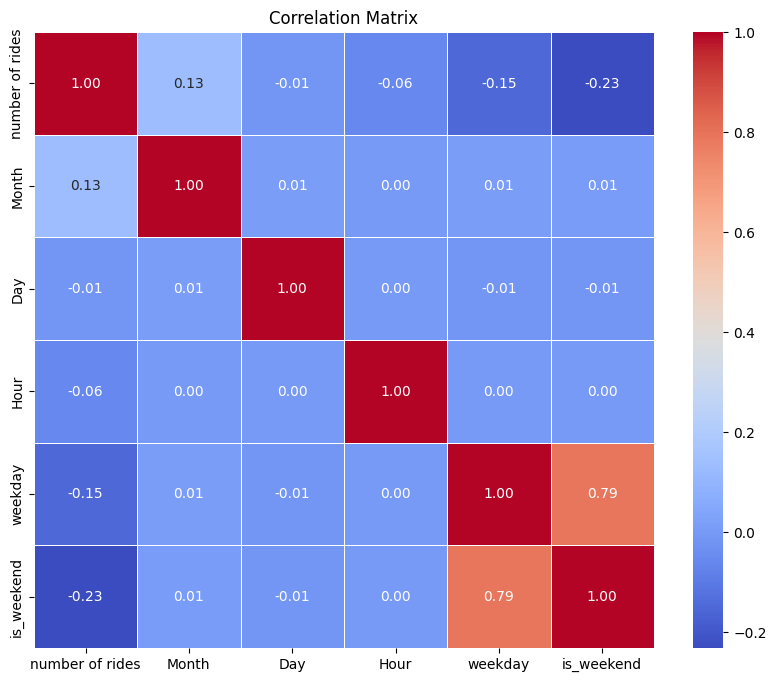

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = hourly_df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


As we can see in the correlation matrix, the weather conditions does not really help in the prediction of number of rides

#Training Preparation

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#remove uneccessary columns
hourly_df = hourly_df.drop(columns = ['temperature_2m', 'precipitation', 'rain', 'snowfall'])

# Separate features (X) and target variable (Y)
X = hourly_df.drop(columns=['number of rides'])   # Exclude 'date' and target column

Y = hourly_df['number of rides']

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Display the resulting splits
print('X_train size is {}'.format(X_train.shape))
print('Y_train size is {}'.format(Y_train.shape))

print('X_test size is {}'.format(X_test.shape))
print('Y_test size is {}'.format(Y_test.shape))

X_train size is (7008, 5)
Y_train size is (7008,)
X_test size is (1752, 5)
Y_test size is (1752,)


#Linear Regression
Good for a baseline model to understand if linear relationships are sufficient.

**bold text**

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, Y_train)

# Make predictions
Y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

# Display the results
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)


Mean Squared Error: 39.680819790085444
R^2 Score: 0.07288295963332814


#Decision Trees
Useful for capturing non-linear relationships without the need for feature scaling

In [11]:
#start with random values
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
# Initialize and train the Decision Tree Regressor model
model = DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42)
model.fit(X_train, Y_train)

# Make predictions
Y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

# Display the results
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)


Mean Squared Error: 15.28992264945105
R^2 Score: 0.6427607113667477


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint


# Define the parameter grid for Random Search
param_distributions = {
    'max_depth': randint(1, 20),  # Max depth of the tree
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 20)  # Minimum number of samples required to be at a leaf node
}

# Initialize the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=dt_regressor,
    param_distributions=param_distributions,
    n_iter=50,  # Number of different combinations to try
    cv=5,  # Number of cross-validation folds
    scoring='neg_mean_squared_error',  # Use negative MSE as the scoring metric
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Perform Random Search
random_search.fit(X_train, Y_train)

# Get the best model and parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Make predictions with the best model
Y_pred = best_model.predict(X_test)

# Evaluate the best model
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

# Display the results
print("Best Parameters:", best_params)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)


Best Parameters: {'max_depth': 15, 'min_samples_leaf': 19, 'min_samples_split': 13}
Mean Squared Error: 14.1969826426379
R^2 Score: 0.6682965573945083


#XGBoost

In [13]:
from xgboost import XGBRegressor

# Initialize XGBoost Regressor
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, Y_train)

# Make predictions
Y_pred = model.predict(X_test)


In [14]:
# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

# Display the results
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)


Mean Squared Error: 12.225266767136173
R^2 Score: 0.7143644409868701
